# Importing Required Libraries

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

%matplotlib inline

## Setup Display - Importing Ipythons display module to aid us in plotting images to out notebook

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# Creating Classes and Functions more towards the Object Oriented Programming Way first

In [4]:
class DQN(nn.Module): # within the nn package there is a class called Module - the base class for all Neural Network Modules
                      # So our network in all of it's layers will extend the nn.Module class
    
    def __init__(self , img_height , img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= img_height*img_width*3 , out_features = 24)
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.out = nn.Linear(in_features = 32 , out_features=2)
        
        
    def forward(self,t): # this function will execute a forward pass to the network ,
                         # all pytorch networks require an implementation of forward
        
        t = t.flatten(start_dim = 1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t     

In [5]:
# We define our DQN as a class that extends nn.Module
# Our DQN will receive inputs as the screenshot images of the Cart Pole Game , so we need height and width
# 2 fully connected layers and an output layer - PyTorch refers to fully connected layers as Linear
# height*weights*3 corresponds to the three colour channels from our RGB inputs recevied by Network
# out_features- Right or Left - only two possible actions

# Note that this network is pretty arbitrary and also very basic, doesn't even contain any convolutional layers
# We first start with a very basic model amnd then make changes to improve the model based on performance and tuning

# For any particular image tensor passed to the network, t will first need to be flattened to be passed to the fully connected layer
# Finally this will be passed to the Fully Connected layers and consequent layers ahead where we finally have the output from Output layer


# SO we have the network , moving on to EXPERIENCES

In [6]:
# Experiences from Replay memory is what we use to rain our network
# We create a class called experience ,
# this class will be used to create instances of experience objects that will get stored in and sampled from replay memory later
# namedtuple is a python function for creating tuples with named fields

Experience = namedtuple('Experience' , ('state','action','reward','next_state')) 

# Here, namedtuple returns a new tuple subclass named "Experience"
# this will be used to create tuple like objects that have the above mentioned fields

In [7]:
e = Experience(2,3,1,4)

In [8]:
e.state , e.action # and so on

(2, 3)

In [9]:
e

Experience(state=2, action=3, reward=1, next_state=4)

# Defining the Replay Memory Class

In [10]:
# it only needs a single parameter which is the capacity

class ReplayMemory():
    
    def __init__(self , capacity):
        
        self.capacity = capacity
        self.memory = [] # Stored experiences in Memory - Replay memory
        self.push_count = 0 # Store how many experiences saved
        
        
    def push(self , experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
            
        else:
            self.memory[self.push_count % self.capacity] = experience # Adding experiences to the front of the memory , FIFO
            
        self.push_count += 1
        
    def sample(self , batch_size):
        
        return random.sample(self.memory , batch_size)
     
    def can_provide_sample(self ,batch_size): # check before we sample ,if we can
        
        return len(self.memory) >= batch_size
    
    


# Exploration - Exploitation Tradeoff Strategy - Epsilon greedy Implementation

In [11]:
class EpsilonGreedyStrategy():
    
    def __init__(self , start , end , decay):
        
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self , current_episode_or_step):
        
        return self.end + (self.start - self.end)*math.exp(-1*current_episode_or_step*self.decay)

# Building the Agent 

In [12]:
class Agent():
    
    def __init__(self , strategy , num_actions , device):    # num_actions corresponds to how many possilbe actions exists
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_actions(self , state , policy_net):
        
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step+=1
        
        if rate > random.random():
            return torch.tensor([random.randrange(self.num_actions)]).to(self.device) # Explore
        else:
            with torch.no_grad(): # Just doing this so we turn off gradient tracking, currently not training, just using
                return policy_net(state).argmax(dim = 1).to(device) # Exploit

# Cart-Pole Environment Manager

In [20]:
class CartPoleEnvManager():
    
    def __init__(self , device):
        
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset() # to get initial observation
        self.current_screen = None # current Screen will drive the current screen of the environement at any given time
        # When set to None , this means we have started an episode and haven't rendered the screen of any observation
        self.done = False
        
        
    def reset(self):
        self.env.reset()
        self.current_screen= None # When at an end of an episode, after resetting
    
    def close(self):
        self.env.close()
        
    def render(self , mode = 'human'):
        return self.env.render(mode)
    
    def num_actions_available(self): # Possible 2 actions available
        return self.env.action_space.n
    
    def take_action(self , action):
        
        # Taking the action and getting the reward
        #print(action)
        
        new_state,reward,self.done ,info = self.env.step(action.item()) 
        
        # .item() beacuse the action passed from main program will be a tensor , item() returns value
        
        return torch.tensor([reward] , device = self.device) # The reward is then returned wrapped in this pytorch tensor
        # Done so to match the format needed in our main program , tensor coming in and tensor going out
    
    def just_starting(self): # True if current screen is none , basically tells if new episode has started or ended
        return self.current_screen is None
    
    def get_state(self): # Return the current state of the environment in the form of a processed image of the screen
        # In this case the input will be screenshot images, 
        # also single state in our environment will be the difference between the current screen and the previous screen
        # This allows the agent to take the velocity of the pole into consideration from one image
        
        if self.just_starting() or self.done: # starting the epsiode or ending it
            self.current_screen = self.get_processed_screen() # returns the processed screen from the environment
            black_screen = torch.zeros_like(self.current_screen) # 0 is black,creating a black screen similar to current
            return black_screen
        else: # somewhere in the middle of the episode
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1
    
    def get_screen_height(self): # returns screens height and weight
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) # Renders the rgb_array of the screen and
        #then transposes this array into the order of channels by height by width which is what our PyTorch DQN will expect
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self , screen):
        screen_height = screen.shape[1]
        
        # Stripping of Top and Bottom 
        top = int(screen_height*0.4) # Thus stripped top 40% and bottom 20%
        bottom = int(screen_height*0.8)
        screen = screen[:,top:bottom , :]
        return screen
    
    def transform_screen_data(self , screen):
        # Convert to float, rescale , convert to Tensor
        screen = np.ascontiguousarray(screen , dtype = np.float32)/255 # All values get stored sequentially in memory
        screen = torch.from_numpy(screen) # also converting individual pixel values into type float32 and then rescaling
        # by dividing with 255 , common process during NN image preocessing
        # finally converting the input screen from a numpy array to a pytorch Tensor
        
        # Use Torchvision package to compose image transforms
        resize = T.Compose([T.ToPILImage() , T.Resize((40,90)) , T.ToTensor()])
        # Chain togther several image transformation - Compose Resize
        # First tensor converted to a PILImage and then resized to a 40 by 90 image
        # PILImage then transformed to a Tensor
        
        ## We pass our screen from above to resize and then add an extra dimension to tensor by calling unsqueeze
        # Added dimension represents a batch dimension since processed image passed to DQN in batches
        
        return resize(screen).unsqueeze(0).to(self.device) # Add a batch        

# Example of a Non-Processed Screen

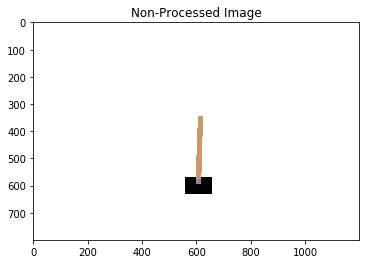

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-Processed Image')
plt.show()

em.close()

# After Processing the Screen 

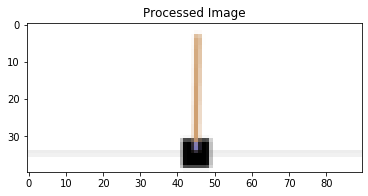

In [35]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
plt.title('Processed Image')
plt.show()

em.close()

# Example of Starting State

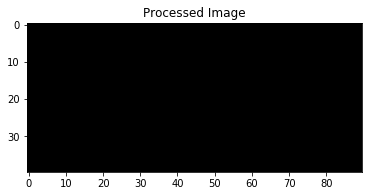

In [36]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
plt.title('Processed Image')
plt.show()

em.close()

# Example of a Non- Starting State

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


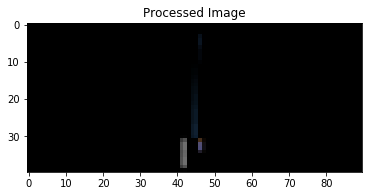

In [37]:
for i in range(5):
    em.take_action(torch.tensor([1]))
    
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
plt.title('Processed Image')
plt.show()

em.close()

# Example of an End state

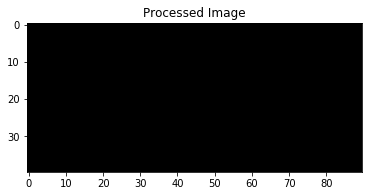

In [38]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
plt.title('Processed Image')
plt.show()

em.close()

# Utility functions available to track performance during Training

In [15]:
def plot(values , moving_average_period):
    # to solve Cart Pole Average reward must be greater than or equal to 195 over 100 episodes
    # Thus, duration is exactly equal to the rewards , as in the game, every time step that does not lead to episode end
    # is a +1 Reward
    
    plt.figure(2)
    plt.clf() # clear current figure
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)# values will be episode durations
    
    moving_avg = get_moving_average(moving_average_period, values)
    
    plt.plot(moving_avg) 
    plt.pause(0.001) # Duration of wait between the plots ( active plot )
    print('Episode' , len(values) , "\n" , moving_average_period , "episode moving average", moving_avg[-1])
    
    if is_ipython : display.clear_output(wait = True)
        
        
def get_moving_average(period, values):
    
    values = torch.tensor(values, dtype = torch.float) # first transform the values to a tensor
    # checking if the dataset is as large as the period of the moving average
    if len(values) >= period:
        
        moving_avg = values.unfold(dimension=0 , size = period , step = 1).mean(dim = 1).flatten(start_dim = 0)
        # the values.unfold() on the tensor returns a tensor that contains all the slices with a size equal
        # to the passed period, it does this on the zeroth dimension on the original values tensor
        # this gives us all slices of size 100 across the original value tensor
        
        # We then mean over all the slcies and flatten the tensor so that now moving average cointains
        # all 100 period moving averages from the values that were passed in 
        
        # finally concatenating this tensor to a tensor of zeros , with a size = period-1 , keeping in mind first 99 values is 0
        # each value after is the actuall 100 period moving average
        moving_avg = torch.cat((torch.zeros(period-1) , moving_avg))
        
        return moving_avg.numpy() # converting the tensor to a numpy array
    
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
  

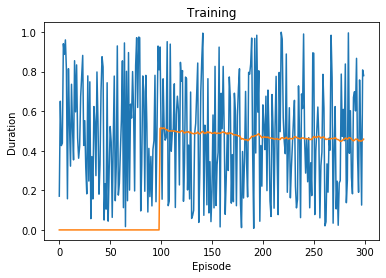

Episode 300 
 100 episode moving average 0.45867372


In [16]:
plot(np.random.rand(300) , 100)

# Final Call of Duty 

### Let's build something Awesome !

# Tensor Processing

In [17]:
def extract_tensors(experiences):
    
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state) # using torch.cat we extract all the states from this batch into their own tensor
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)


# Example Usage

e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)
e4 = Experience(4,4,4,4)

experiences = [e1,e2,e3,e4]
print(experiences)

batch = Experience(*zip(*experiences))
print(batch)


[Experience(state=1, action=1, reward=1, next_state=1), Experience(state=2, action=2, reward=2, next_state=2), Experience(state=3, action=3, reward=3, next_state=3), Experience(state=4, action=4, reward=4, next_state=4)]
Experience(state=(1, 2, 3, 4), action=(1, 2, 3, 4), reward=(1, 2, 3, 4), next_state=(1, 2, 3, 4))


# Q Value Evaluation Class

In [18]:
class QValues():
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net , states , actions):
        # this function just returns the predicted QValues 
        # from the policy net for the specific state action pairs that were passed in
        
        return policy_net(states).gather(dim = 1 , index = actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_network , next_states):
        
        # this function does as follows-
        # 1. Accepts a target net and next_states
        # 2. Since we want maximum possible Q -value among all possible actions from a state
        # 3. So we first look in our next_states tensor and find the locations of all the final states
        # 4. If an episode is ended by a given action , then,
        #    we call the next state that occured after the action as final state
        # 5. The final state is an all black screen,thus all values within tensor representing final state will be 0
        #   We want to know where the final states are if at all they exist,because,
        #   we dont want to pass these final states to our target net to get a predicted q values,because,
        #   We know the q values are zero because the agent does not receive any reward in the final terminal states
        #   So we find the locations of these final states, to not pass them to targetnet when we pass the non final states

        
        final_state_locations = next_states.flatten(start_dim = 1).max(dim = 1)[0].eq(0).type(torch.bool)
        # to find the location of these potential final states, we first flatten the next states tensor along dimension 1
        # and check each individual next states to find it's max value, if equal to zero ,
        # then we know this state is a final state 
        # and we represent that as true within final states tensor and the others are represented as a false
        
        non_final_state_locations = (final_state_locations==False) # Exact opposite of final_state_locations
        # true for non final and false for final

        non_final_states = next_states[non_final_state_locations]
        # Now we know non final statesvalue , so we get them by indexing in the next states tensor
        # and get all correspondong non final states
        
        batch_size = next_states.shape[0]
        # Next we find the batch size by checking to see how many next states are in the next states tensor
        
        values = torch.zeros(batch_size).to(QValues.device)
        # so we create new tensors of zeros of length the same size as bacth size next_states and send it to device
        
        values[non_final_state_locations] = target_network(non_final_states).max(dim = 1)[0].detach()
        # we finally index into these tensor of zeros with the non final state locations and set the corresponding
        # values of all these locations equal to the max predicted q values from the traget next across each action
        # Therefore for final states we have 0 and for the non final states maximum predicted q values across all action tensor
        # this result is returned
        return values
    
        

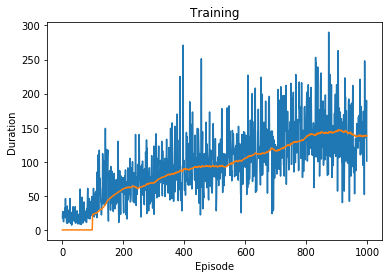

Episode 1000 
 100 episode moving average 138.12


In [21]:
# Main Program 

# Setting all Hyper parameters

BATCH_SIZE = 256
DISCOUNT_RATE_GAMMA = 0.999
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.001
TARGET_UPDATE_RATE = 10
MEMORY_SIZE = 100000

LEARNING_RATE_ALPHA = 0.001
EPISODES = 1000



# Creating Object Instances of the classes created above

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(EPS_START , EPS_END , EPS_DECAY)
agent = Agent(strategy , env.num_actions_available() ,device)
memory = ReplayMemory(MEMORY_SIZE)

policy_network = DQN(env.get_screen_height() , env.get_screen_width()).to(device)
target_network = DQN(env.get_screen_height() , env.get_screen_width()).to(device)

target_network.load_state_dict(policy_network.state_dict())
target_network.eval() # putting target_net in eval mode ,this tells PyTorch that this network is not in training mode
# Therefore it will only be used for inference

optimizer = optim.Adam(params = policy_network.parameters() , lr = LEARNING_RATE_ALPHA)



episode_durations = []

for episode in range(EPISODES):
    
    env.reset()
    state = env.get_state()
    
    for timestep in count():
        
        action = agent.select_actions(state , policy_network)
        reward = env.take_action(action)
        next_state = env.get_state()
        memory.push(Experience(state,action,reward,next_state))
        state = next_state
        
        
        if memory.can_provide_sample(BATCH_SIZE):
            experiences = memory.sample(BATCH_SIZE)
            states, actions , rewards , next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_network , states , actions)
            # this returns the qvalues for the state action pair passed based on the policy network
            
            next_q_values = QValues.get_next(target_network, next_states)
            # this gives the max Q value for the next states using the best corresponding actions
            # using the target network
            
            target_q_values = (next_q_values*DISCOUNT_RATE_GAMMA) + rewards
            
            
            loss = F.mse_loss(current_q_values , target_q_values.unsqueeze(1))
            # We now zero out the grdients using optimizer class's zero_grad()
            
            optimizer.zero_grad()
            # This function sets the gradient of all the weights and biases in the policy net to 0
            # since pytorch accumulates the gradients before backprop , we need to do this before backprop
            
            loss.backward() # computes gradients of the loss wrt all the weights and biases in the PN
            optimizer.step() # Updates the weights and biases computed using loss gradient during loss.backward
            
            
        if env.done:
            
            episode_durations.append(timestep)
            plot(episode_durations , 100)
            break
            
        
    if episode%TARGET_UPDATE_RATE == 0:
            
        target_network.load_state_dict(policy_network.state_dict())
            

env.close()
            